## Imports Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, utils, losses, optimizers, initializers, regularizers
from keras.wrappers import scikit_learn
from keras.models import *
from keras.layers import *
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.utils import np_utils, image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

import random
import pandas as pd
import numpy as np
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Reads the `txt` File Specifying the Image File Locations

In [2]:
# flist = list(pd.read_csv('flist.txt', header = None)[0])
flist = list(pd.read_csv('/kaggle/input/dissertation-1-data/Files/flist.txt', header = None)[0])

## Overview of the `properties` Dataset

Read the `properties` dataset first, and make sure that `property type` is a categorical variable.

In [3]:
# properties = pd.read_csv('properties.csv')
# properties_juny12 = pd.read_csv('properties_juny12.csv')
properties = pd.read_csv('/kaggle/input/dissertation-1-data/Files/properties.csv')
properties_juny12 = pd.read_csv('/kaggle/input/dissertation-1-data/Files/properties_juny12.csv')

properties_full = pd.concat([properties, properties_juny12])
properties = properties_full
properties.propertyType = properties.propertyType.astype('category')
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37402 entries, 0 to 19851
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    37402 non-null  int64   
 1   address       37402 non-null  object  
 2   propertyType  37402 non-null  category
 3   bedrooms      24486 non-null  float64 
 4   detailUrl     37402 non-null  object  
 5   location_lat  37402 non-null  float64 
 6   location_lng  37402 non-null  float64 
 7   property_id   37402 non-null  object  
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 2.3+ MB


## A Subset of the `properties` Dataset

As random samples of images have been obtained previously, a subset of the whole `properties` dataset could hence be formulated by selecting the rows of the whole `properties` dataset corresponding to the selected samples.

In [4]:
flist_id = list(map(lambda string: string[-40 : -4], flist))
properties_sub = pd.DataFrame(properties.loc[properties['property_id'].isin(flist_id)])
properties_sub = properties_sub.drop_duplicates(['location_lat', 'location_lng'])

# properties_sub = pd.read_csv('properties_sub.csv')
# properties_sub = pd.read_csv('/kaggle/input/dissertation-1-data/Files/properties_sub.csv')

properties_sub.propertyType = properties_sub.propertyType.astype('category')
flist_id = list(properties_sub.property_id)
properties_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15484 entries, 0 to 19851
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Unnamed: 0    15484 non-null  int64   
 1   address       15484 non-null  object  
 2   propertyType  15484 non-null  category
 3   bedrooms      10967 non-null  float64 
 4   detailUrl     15484 non-null  object  
 5   location_lat  15484 non-null  float64 
 6   location_lng  15484 non-null  float64 
 7   property_id   15484 non-null  object  
dtypes: category(1), float64(3), int64(1), object(3)
memory usage: 983.1+ KB


In [5]:
properties_sub.propertyType.value_counts(sort = False)

Detached         3337
Flat             2252
Semi-Detached    4062
Terraced         4124
Unknown          1709
Name: propertyType, dtype: int64

The original data should be splitted into training and testing sets, and the testing set contains 30% of the original data.

In [6]:
# directory = 'street_view/'
directory = '/kaggle/input/dissertation-1-data/Files/street_view/'

height = 64
width = 64
batch = 32
seed = np.random.randint(1, np.power(2, 32) - 1)

tr_val = image_dataset_from_directory(
  directory,
  validation_split = .3,
  subset = 'both',
  seed = seed,
  image_size = (height, width),
  batch_size = batch,
  label_mode = 'categorical')

training = tr_val[0]
validation = tr_val[1]
training = training.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation = validation.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

Found 13775 files belonging to 4 classes.
Using 9643 files for training.
Using 4132 files for validation.


In [7]:
val_bat = tf.data.experimental.cardinality(validation)
validation = validation.skip((2 * val_bat) // 3)
testing = validation.take((2 * val_bat) // 3)

## Multi-Class Classification Using Neural Network

In [8]:
propertyType_train_fac = np.argmax(np.asarray(list(training.unbatch().map(lambda x, y: y))), axis = 1)
propertyType_test_fac = np.argmax(np.asarray(list(testing.unbatch().map(lambda x, y: y))), axis = 1)
labels = pd.Series(propertyType_train_fac).astype('category')

In [9]:
loss = losses.CategoricalCrossentropy()
weights = sum(labels.value_counts()) / (labels.value_counts(sort = False) * len(labels.cat.categories))
loss.weighted = weights

In [10]:
lr = 5e-4
Callbacks = [
             EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 8, restore_best_weights = True), 
             ReduceLROnPlateau(monitor = 'val_accuracy', factor = 4e-2, patience = 0, cooldown = 0)
            ]

In [11]:
def visualise_accuracy_loss(history):
    
    ac = history.history['accuracy']
    val_ac = history.history['val_accuracy']

    lo = history.history['loss']
    val_lo = history.history['val_loss']
    
    epoch = len(ac)
    epoch_vec = np.arange(epoch) + 1

    plt.figure(figsize = (10, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_vec, ac, label = 'Training Accuracy')
    plt.plot(epoch_vec, val_ac, label = 'Validation Accuracy')
    plt.legend(loc = 'lower right')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_vec, lo, label = 'Training Loss')
    plt.plot(epoch_vec, val_lo, label = 'Validation Loss')
    plt.legend(loc = 'upper right')
    plt.title('Model Loss')
    plt.show()

### Multi-Layer Perceptron Model

In [12]:
mlp = Sequential([
                  Rescaling(1. / 255, input_shape = (height, width, 3)),
                  Flatten(),
                  Dense(160, activation = tf.nn.leaky_relu),
                  Dense(
                        len(labels.cat.categories), 
                        activation = tf.nn.softmax, 
                        kernel_initializer = initializers.RandomNormal(),
                        bias_initializer = initializers.Zeros(),
                        kernel_regularizer = regularizers.L1(1e-5),
                        bias_regularizer = regularizers.L1(10),
                        activity_regularizer = regularizers.L1(10)
                       )
                ])
mlp.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = lr), metrics = ['accuracy'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 160)               1966240   
                                                                 
 dense_1 (Dense)             (None, 4)                 644       
                                                                 
Total params: 1,966,884
Trainable params: 1,966,884
Non-trainable params: 0
_________________________________________________________________


Epoch 1/60
302/302 [==============================] - 5s 5ms/step - loss: 11.4381 - accuracy: 0.3232 - val_loss: 11.4852 - val_accuracy: 0.3290 - lr: 5.0000e-04
Epoch 2/60
302/302 [==============================] - 1s 4ms/step - loss: 11.3255 - accuracy: 0.3694 - val_loss: 11.3777 - val_accuracy: 0.3275 - lr: 5.0000e-04
Epoch 3/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2477 - accuracy: 0.4261 - val_loss: 11.2631 - val_accuracy: 0.3855 - lr: 2.0000e-05
Epoch 4/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2418 - accuracy: 0.4287 - val_loss: 11.2606 - val_accuracy: 0.3870 - lr: 2.0000e-05
Epoch 5/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2395 - accuracy: 0.4318 - val_loss: 11.2577 - val_accuracy: 0.3986 - lr: 2.0000e-05
Epoch 6/60
302/302 [==============================] - 1s 4ms/step - loss: 11.2366 - accuracy: 0.4338 - val_loss: 11.2600 - val_accuracy: 0.4036 - lr: 2.0000e-05
Epoch 7/60
302/302 [==============

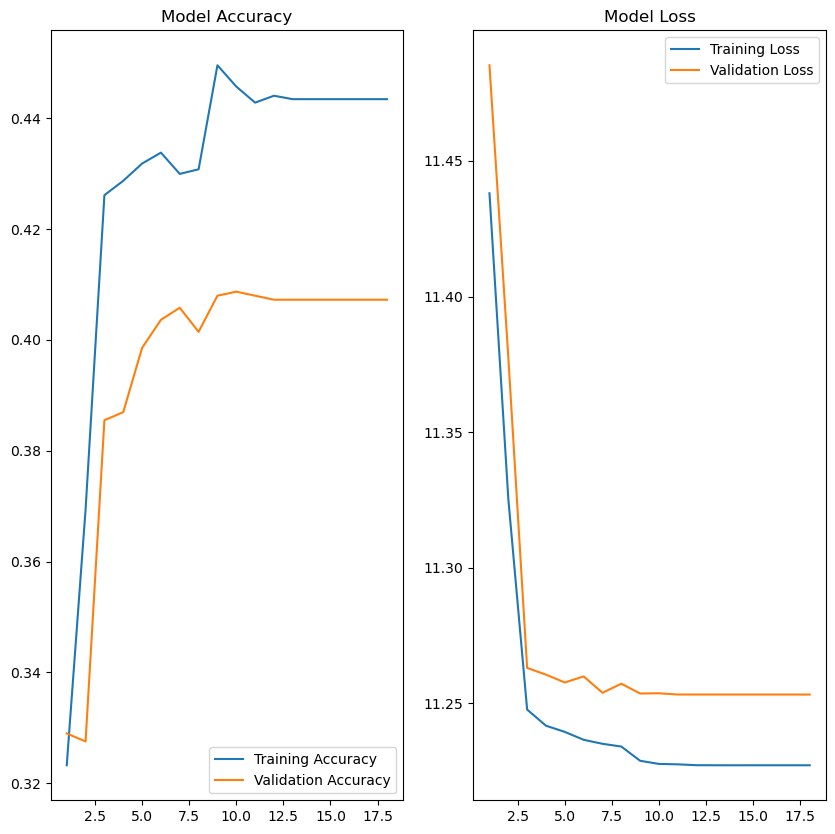

In [13]:
history = mlp.fit(training, validation_data = validation, epochs = 60, batch_size = 50, callbacks = Callbacks)
visualise_accuracy_loss(history)

44/44 [==============================] - 0s 2ms/step


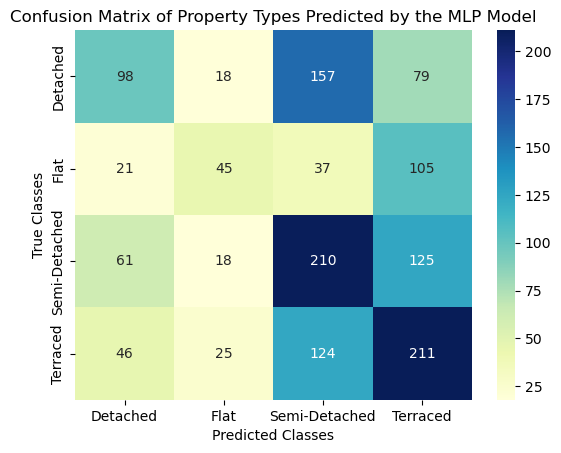

In [14]:
propertyType_test_pred_MLP = np.argmax(mlp.predict(testing), axis = 1)
label_names = ['Detached', 'Flat', 'Semi-Detached', 'Terraced']
confmat_MLP = pd.DataFrame(confusion_matrix(propertyType_test_fac, propertyType_test_pred_MLP))

ax = plt.axes()
sns.heatmap(confmat_MLP, annot = True, 
            cmap = 'YlGnBu', fmt = 'g', 
            cbar = True, xticklabels = label_names, 
            yticklabels = label_names, ax = ax)  
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
ax.set_title('Confusion Matrix of Property Types Predicted by the MLP Model')
plt.show()

In [15]:
print(
      classification_report(
                      propertyType_test_fac, 
                      propertyType_test_pred_MLP, 
                      target_names = label_names
      )
)

               precision    recall  f1-score   support

     Detached       0.43      0.28      0.34       352
         Flat       0.42      0.22      0.29       208
Semi-Detached       0.40      0.51      0.45       414
     Terraced       0.41      0.52      0.46       406

     accuracy                           0.41      1380
    macro avg       0.42      0.38      0.38      1380
 weighted avg       0.41      0.41      0.40      1380



## Convolutional Neural Network Model

In [16]:
cnn = Sequential([
                  Rescaling(1. / 255, input_shape = (height, width, 3)),
                  Conv2D(50, 4, padding = 'same', activation = tf.nn.leaky_relu),
                  MaxPooling2D(pool_size = (2, 2)),
                  Conv2D(48, 4, padding = 'same', activation = tf.nn.leaky_relu),
                  MaxPooling2D(pool_size = (2, 2)),
                  Flatten(),
                  Dense(42, activation = tf.nn.leaky_relu),
                  Dropout(.25),
                  Dense(
                        len(labels.cat.categories), 
                        activation = tf.nn.softmax, 
                        kernel_initializer = initializers.RandomNormal(),
                        bias_initializer = initializers.Zeros(),
                        kernel_regularizer = regularizers.L1(1e-5),
                        bias_regularizer = regularizers.L1(10),
                        activity_regularizer = regularizers.L1(10)
                       )
                ])
cnn.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = lr), metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 50)        2450      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 48)        38448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 48)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 12288)            

Epoch 1/60
302/302 [==============================] - 9s 10ms/step - loss: 11.3071 - accuracy: 0.3669 - val_loss: 11.2611 - val_accuracy: 0.4000 - lr: 5.0000e-04
Epoch 2/60
302/302 [==============================] - 3s 9ms/step - loss: 11.2582 - accuracy: 0.4115 - val_loss: 11.2378 - val_accuracy: 0.4312 - lr: 5.0000e-04
Epoch 3/60
302/302 [==============================] - 3s 8ms/step - loss: 11.2298 - accuracy: 0.4351 - val_loss: 11.2232 - val_accuracy: 0.4326 - lr: 5.0000e-04
Epoch 4/60
302/302 [==============================] - 3s 8ms/step - loss: 11.2064 - accuracy: 0.4545 - val_loss: 11.2289 - val_accuracy: 0.4362 - lr: 5.0000e-04
Epoch 5/60
302/302 [==============================] - 2s 8ms/step - loss: 11.1751 - accuracy: 0.4678 - val_loss: 11.2311 - val_accuracy: 0.4254 - lr: 5.0000e-04
Epoch 6/60
302/302 [==============================] - 2s 8ms/step - loss: 11.1220 - accuracy: 0.5032 - val_loss: 11.2080 - val_accuracy: 0.4630 - lr: 2.0000e-05
Epoch 7/60
302/302 [=============

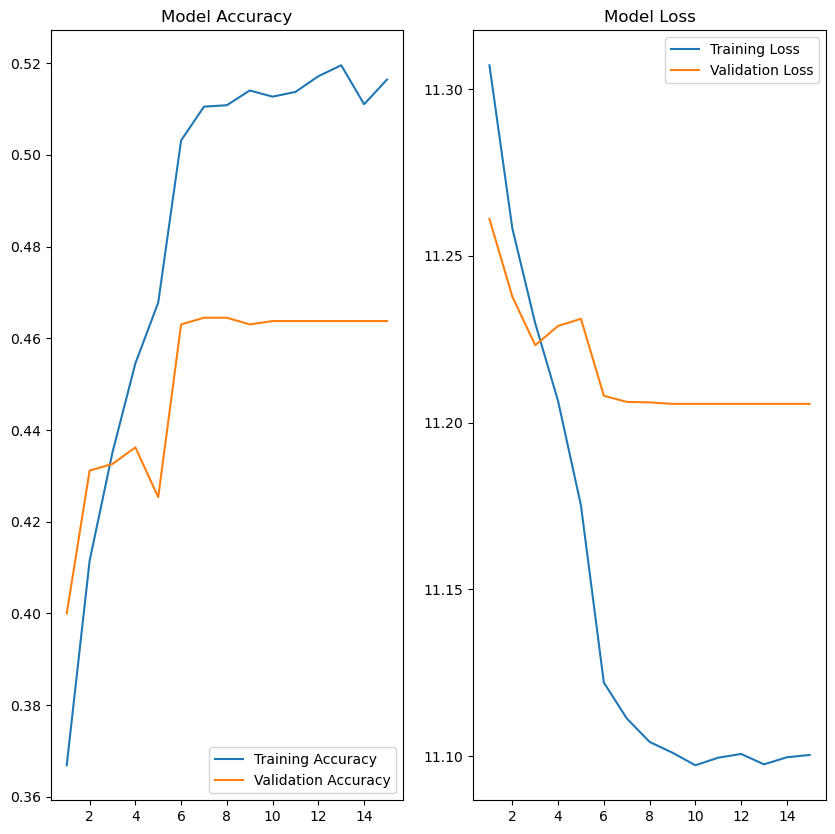

In [17]:
history = cnn.fit(training, validation_data = validation, epochs = 60, batch_size = 50, callbacks = Callbacks)
visualise_accuracy_loss(history)

44/44 [==============================] - 0s 3ms/step


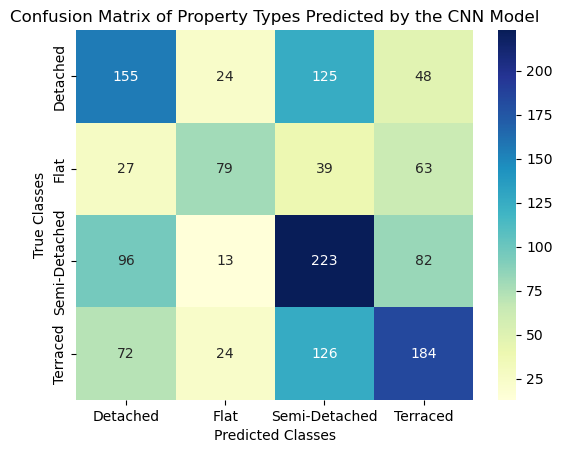

In [18]:
propertyType_test_pred_CNN = np.argmax(cnn.predict(testing), axis = 1)
label_names = ['Detached', 'Flat', 'Semi-Detached', 'Terraced']
confmat_CNN = confusion_matrix(propertyType_test_fac, propertyType_test_pred_CNN)

ax = plt.axes()
sns.heatmap(confmat_CNN, annot = True, 
            cmap = 'YlGnBu', fmt = 'g', 
            cbar = True, xticklabels = label_names, 
            yticklabels = label_names, ax = ax)  
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
ax.set_title('Confusion Matrix of Property Types Predicted by the CNN Model')
plt.show()

In [19]:
print(
      classification_report(
                      propertyType_test_fac, 
                      propertyType_test_pred_CNN, 
                      target_names = label_names
      )
)

               precision    recall  f1-score   support

     Detached       0.44      0.44      0.44       352
         Flat       0.56      0.38      0.45       208
Semi-Detached       0.43      0.54      0.48       414
     Terraced       0.49      0.45      0.47       406

     accuracy                           0.46      1380
    macro avg       0.48      0.45      0.46      1380
 weighted avg       0.47      0.46      0.46      1380



In [20]:
cnn2 = Sequential([
                  Rescaling(1. / 255, input_shape = (height, width, 3)),
                  Conv2D(50, 4, padding = 'same', activation = tf.nn.leaky_relu),
                  MaxPooling2D(pool_size = (2, 2)),
                  Conv2D(48, 4, padding = 'same', activation = tf.nn.leaky_relu),
                  MaxPooling2D(pool_size = (2, 2)),
                  Flatten(),
                  Dense(42, activation = tf.nn.leaky_relu),
                  Dropout(.25),
                  Dense(
                        len(labels.cat.categories), 
                        activation = tf.nn.softmax, 
                        kernel_initializer = initializers.RandomNormal(),
                        bias_initializer = initializers.Zeros(),
                        kernel_regularizer = regularizers.L1(1e-4),
                        bias_regularizer = regularizers.L1(1),
                        activity_regularizer = regularizers.L1(1)
                       )
                ])
cnn2.compile(loss = loss, optimizer = optimizers.Adam(learning_rate = lr), metrics = ['accuracy'])
cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 50)        2450      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 48)        38448     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 48)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 12288)            

Epoch 1/60
302/302 [==============================] - 3s 9ms/step - loss: 2.3007 - accuracy: 0.3720 - val_loss: 2.2580 - val_accuracy: 0.4145 - lr: 5.0000e-04
Epoch 2/60
302/302 [==============================] - 3s 8ms/step - loss: 2.2498 - accuracy: 0.4203 - val_loss: 2.2439 - val_accuracy: 0.3986 - lr: 5.0000e-04
Epoch 3/60
302/302 [==============================] - 3s 8ms/step - loss: 2.2102 - accuracy: 0.4447 - val_loss: 2.2275 - val_accuracy: 0.4304 - lr: 2.0000e-05
Epoch 4/60
302/302 [==============================] - 3s 8ms/step - loss: 2.2016 - accuracy: 0.4571 - val_loss: 2.2210 - val_accuracy: 0.4384 - lr: 2.0000e-05
Epoch 5/60
302/302 [==============================] - 3s 8ms/step - loss: 2.1985 - accuracy: 0.4590 - val_loss: 2.2198 - val_accuracy: 0.4449 - lr: 2.0000e-05
Epoch 6/60
302/302 [==============================] - 3s 8ms/step - loss: 2.1916 - accuracy: 0.4587 - val_loss: 2.2164 - val_accuracy: 0.4457 - lr: 2.0000e-05
Epoch 7/60
302/302 [==========================

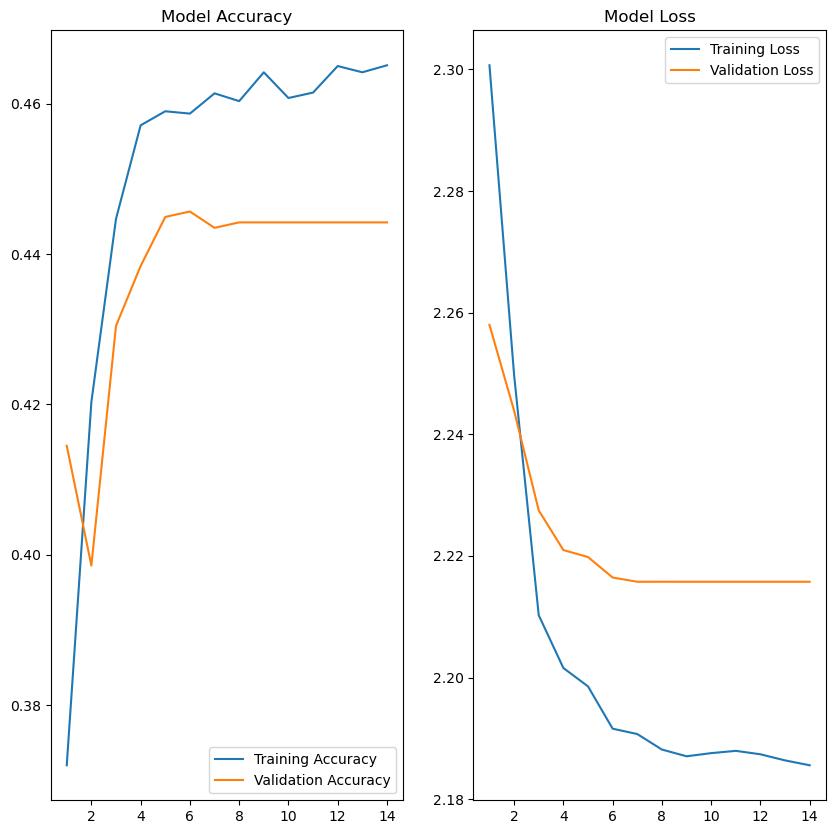

In [21]:
history = cnn2.fit(training, validation_data = validation, epochs = 60, batch_size = 50, callbacks = Callbacks)
visualise_accuracy_loss(history)

44/44 [==============================] - 0s 3ms/step


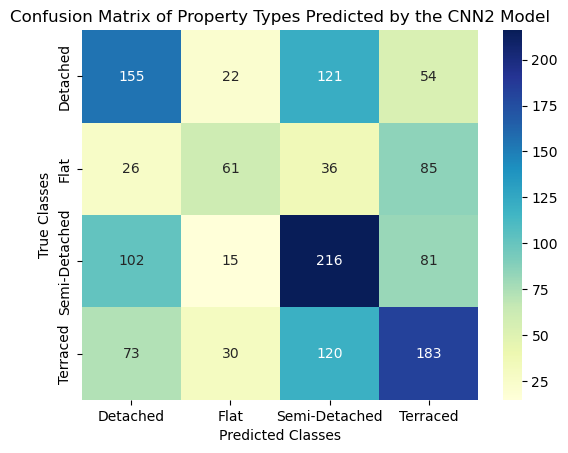

In [22]:
propertyType_test_pred_CNN2 = np.argmax(cnn2.predict(testing), axis = 1)
label_names = ['Detached', 'Flat', 'Semi-Detached', 'Terraced']
confmat_CNN2 = confusion_matrix(propertyType_test_fac, propertyType_test_pred_CNN2)

ax = plt.axes()
sns.heatmap(confmat_CNN2, annot = True, 
            cmap = 'YlGnBu', fmt = 'g', 
            cbar = True, xticklabels = label_names, 
            yticklabels = label_names, ax = ax)  
ax.set_xlabel('Predicted Classes')
ax.set_ylabel('True Classes')
ax.set_title('Confusion Matrix of Property Types Predicted by the CNN2 Model')
plt.show()

In [23]:
print(
      classification_report(
                      propertyType_test_fac, 
                      propertyType_test_pred_CNN2, 
                      target_names = label_names
      )
)

               precision    recall  f1-score   support

     Detached       0.44      0.44      0.44       352
         Flat       0.48      0.29      0.36       208
Semi-Detached       0.44      0.52      0.48       414
     Terraced       0.45      0.45      0.45       406

     accuracy                           0.45      1380
    macro avg       0.45      0.43      0.43      1380
 weighted avg       0.45      0.45      0.44      1380

